In [30]:
#Importing necessary libraries
import hopsworks
import hsfs
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler  # Import StandardScaler from scikit-learn
import joblib
from prophet import Prophet

load_dotenv()

#Connecting to hopsworks
api_key = os.environ.get('HOPSWORKS_API')
project = hopsworks.login(api_key_value=api_key)
fs = project.get_feature_store()

#Another connection to hopsworks
api_key = os.getenv('HOPSWORKS_API')
connection = hsfs.connection()
fs = connection.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/564374
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [31]:
#Getting the feature view
feature_view = fs.get_feature_view(
    name='amd_stock_fv',
    version=23
)

In [32]:
df = feature_view.get_batch_data(read_options={"use_hive": True})


2024-10-16 18:33:13,497 WARNING: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated

Finished: Reading data from Hopsworks, using Hive (2.60s) 


In [5]:
# Inspect sample 'date' values before conversion
print("Sample 'date' values before conversion:")
print(df['date'].head())

Sample 'date' values before conversion:
0   2001-02-27
1   2018-02-23
2   2005-01-21
3   2003-11-24
4   2002-12-13
Name: date, dtype: datetime64[ns]


In [33]:
# Convert 'date' to datetime with error handling
df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [9]:
# Drop rows with invalid 'date'
initial_count = len(df)
df = df.dropna(subset=['date'])
dropped_count = initial_count - len(df)
if dropped_count > 0:
    print(f"Dropped {dropped_count} rows due to invalid 'date'.")


In [10]:
df = df.sort_values('date')

In [11]:
print("Columns in df:")
print(df.columns.tolist())

Columns in df:
['date', 'f_1__open']


In [25]:
df.head()

,date,f_1__open
2122,1999-11-01,19.94
28,1999-11-02,20.31
2381,1999-11-03,20.69
658,1999-11-04,21.13
1163,1999-11-05,20.75


In [12]:
# Prepare prophet_df
prophet_df = df[['date', 'f_1__open']].rename(columns={'date': 'ds', 'f_1__open': 'y'})
print("Columns in Prophet_df:")
print(prophet_df.columns.tolist())

Columns in Prophet_df:
['ds', 'y']


In [13]:
# Inspect sample 'ds' values after conversion
print("Sample 'ds' values after conversion:")
print(prophet_df['ds'].head())

Sample 'ds' values after conversion:
2122   1999-11-01
28     1999-11-02
2381   1999-11-03
658    1999-11-04
1163   1999-11-05
Name: ds, dtype: datetime64[ns]


In [15]:
# Remove timezone information from 'ds' column
prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)

In [16]:
# Ensure the data is sorted by date
prophet_df.sort_values('ds', inplace=True)

In [37]:
prophet_df['ds'].head()

2122   1999-11-01
28     1999-11-02
2381   1999-11-03
658    1999-11-04
1163   1999-11-05
Name: ds, dtype: datetime64[ns]

In [17]:
# Verify the data range in prophet_df
if prophet_df['ds'].isnull().all():
    print("Data range in prophet_df: NaT to NaT")
else:
    min_date = prophet_df['ds'].min()
    max_date = prophet_df['ds'].max()
    print("Data range in prophet_df:", min_date.date(), "to", max_date.date())

Data range in prophet_df: 1999-11-01 to 2024-10-15


In [18]:
# Define train and test split dates as specified
train_start = "2020-03-10"
train_end = "2023-12-31"

test_start = "2024-01-01"
test_end = "2024-10-14"

train_start_date = pd.to_datetime(train_start)
train_end_date = pd.to_datetime(train_end)
test_start_date = pd.to_datetime(test_start)
test_end_date = pd.to_datetime(test_end)


In [20]:
# Check if max_date is valid
if pd.isnull(max_date):
    print("Maximum date is NaT. Cannot proceed with splitting.")
else:
    # Check if test_start_date is after max_date
    if test_start_date > max_date:
        print("Test start date is after the last date in the data. Adjusting test_start_date.")
        test_start_date = max_date - pd.DateOffset(years=1) + pd.DateOffset(days=1)
        print(f"Adjusted test_start_date to: {test_start_date.date()}")
    
    # Check if test_end_date is after max_date
    if test_end_date > max_date:
        print("Test end date is after the last date in the data. Adjusting test_end_date.")
        test_end_date = max_date
        print(f"Adjusted test_end_date to: {test_end_date.date()}")
    
    print(f"Training period: {train_start_date.date()} to {train_end_date.date()}")
    print(f"Testing period: {test_start_date.date()} to {test_end_date.date()}")

     # Split the data
    train_df = prophet_df[
        (prophet_df['ds'] >= train_start_date) & (prophet_df['ds'] <= train_end_date)
    ].copy()
    
    test_df = prophet_df[
        (prophet_df['ds'] >= test_start_date) & (prophet_df['ds'] <= test_end_date)
    ].copy()
    
    print(f"Training DataFrame has {len(train_df)} records.")
    print(f"Testing DataFrame has {len(test_df)} records.")

Training period: 2020-03-10 to 2023-12-31
Testing period: 2024-01-01 to 2024-10-14
Training DataFrame has 960 records.
Testing DataFrame has 198 records.


2024-10-16 17:55:21,730 DEBUG: cmd: where.exe tbb.dll
cwd: None
2024-10-16 17:55:21,789 DEBUG: TBB already found in load path
2024-10-16 17:55:21,809 DEBUG: input tempfile: C:\Users\svjen\AppData\Local\Temp\tmphgm8fgao\fdjm3qvh.json
2024-10-16 17:55:21,870 DEBUG: input tempfile: C:\Users\svjen\AppData\Local\Temp\tmphgm8fgao\jyezyfap.json
2024-10-16 17:55:21,873 DEBUG: idx 0
2024-10-16 17:55:21,874 DEBUG: running CmdStan, num_threads: None
2024-10-16 17:55:21,874 DEBUG: CmdStan args: ['C:\\Users\\svjen\\OneDrive\\Skrivebord\\Github_repos\\ML_ops_stocks\\.conda\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=69631', 'data', 'file=C:\\Users\\svjen\\AppData\\Local\\Temp\\tmphgm8fgao\\fdjm3qvh.json', 'init=C:\\Users\\svjen\\AppData\\Local\\Temp\\tmphgm8fgao\\jyezyfap.json', 'output', 'file=C:\\Users\\svjen\\AppData\\Local\\Temp\\tmphgm8fgao\\prophet_modelwnouca5o\\prophet_model-20241016175521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


17:55:21 - cmdstanpy - INFO - Chain [1] start processing


2024-10-16 17:55:21,875 INFO: Chain [1] start processing


17:55:22 - cmdstanpy - INFO - Chain [1] done processing


2024-10-16 17:55:22,069 INFO: Chain [1] done processing
Prophet model trained successfully.
2024-10-16 17:55:22,147 WARNING: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.


Mean Absolute Error (MAE): 30.703328626950128
Root Mean Squared Error (RMSE): 36.293742568320745


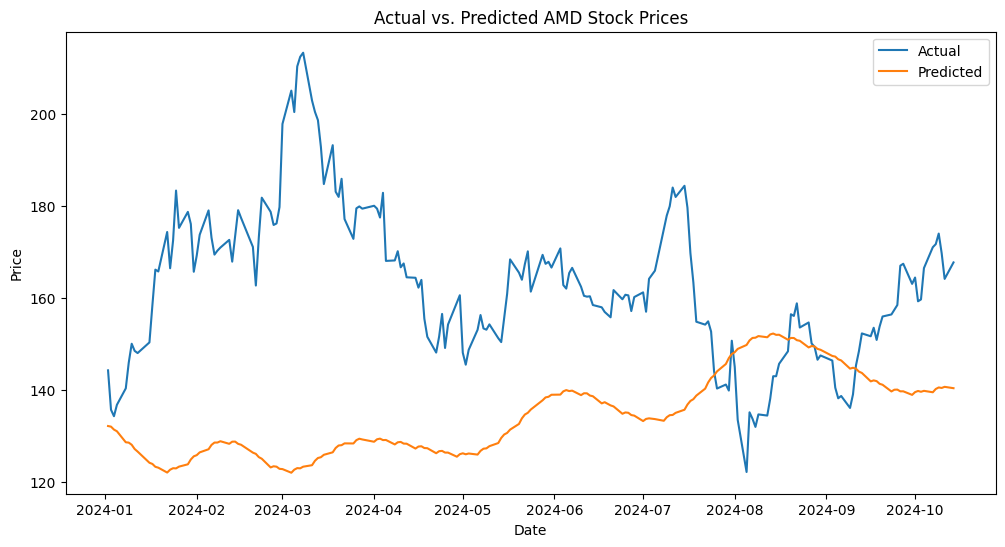

Prophet model saved successfully as 'prophet_model.pkl'.
Connected. Call `.close()` to terminate connection gracefully.
Accessed Hopsworks Model Registry.
Model 'ProphetModel' created successfully in the registry.
Moved model file to 'prophet_model_dir'.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/103835 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/23 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/269 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/564374/models/ProphetModel/15
Model 'ProphetModel' saved successfully to the Hopsworks Model Registry.


In [22]:
import hopsworks
from dotenv import load_dotenv
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import matplotlib.pyplot as plt
import joblib
import shutil
from hsml.schema import Schema
from hsml.model_schema import ModelSchema


# Check if test_df is not empty and ds has valid dates
if test_df.empty or prophet_df['ds'].isnull().all():
    print("Test DataFrame is empty or 'ds' contains only NaT. Please check the test date range.")
else:
    # Proceed with modeling
    model = Prophet(daily_seasonality=True)
    model.fit(train_df)
    print("Prophet model trained successfully.")
    
    # Using the dates from the test set for prediction
    future_dates = test_df[['ds']]
    
    # Generate forecasts
    forecast = model.predict(future_dates)
    
    # Merge the forecast with the actual test data
    forecast_df = forecast[['ds', 'yhat']].set_index('ds')
    actual_df = test_df.set_index('ds')
    
    comparison_df = actual_df.join(forecast_df, how='left').dropna()
    
    # Sort the data by date (ascending order)
    comparison_df.sort_index(inplace=True)
    
    # Compute evaluation metrics
    mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
    rmse = mean_squared_error(comparison_df['y'], comparison_df['yhat'], squared=False)
    
    print(f"\nMean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    
    # Visualize the results
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df.index, comparison_df['y'], label='Actual')
    plt.plot(comparison_df.index, comparison_df['yhat'], label='Predicted')
    plt.legend()
    plt.title('Actual vs. Predicted AMD Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
    
    # Save the trained Prophet model to a file
    joblib.dump(model, 'prophet_model.pkl')
    print("Prophet model saved successfully as 'prophet_model.pkl'.")
    
    
    # Register the model with Hopsworks Model Registry
    # Get the model registry
    mr = project.get_model_registry()
    print("Accessed Hopsworks Model Registry.")
    
    # Define the model name and metadata
    model_name = "ProphetModel"
    description = "Prophet model for time series forecasting AMD stock prices"
    
    # Prepare the input example 
    input_example = train_df[['ds']].head(1)
    input_schema = Schema(input_example)
    
    # Prepare the output example
    output_example = forecast[['yhat']].head(1)
    output_schema = Schema(output_example)
    
    # Create the model schema
    model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)
    
    # Define evaluation metrics
    metrics = {
        'MAE': mae,
        'RMSE': rmse
    }
    
    # Create the model in the registry
    model_registry_entry = mr.python.create_model(
        name=model_name,
        description=description,
        input_example=input_example,
        model_schema=model_schema,
        metrics=metrics
    )
    print(f"Model '{model_name}' created successfully in the registry.")
    
    # Ensure the model directory exists
    model_dir = 'prophet_model_dir'
    os.makedirs(model_dir, exist_ok=True)
    
    # Move the model file into the model directory
    shutil.move('prophet_model.pkl', os.path.join(model_dir, 'prophet_model.pkl'))
    print(f"Moved model file to '{model_dir}'.")
    
    # Save the model artifacts to Hopsworks
    model_registry_entry.save(model_dir)
    print(f"Model '{model_name}' saved successfully to the Hopsworks Model Registry.")

In [38]:
api_key = os.environ.get('HOPSWORKS_API')
if not api_key:
    raise ValueError("HOPSWORKS_API environment variable is not set or is empty.")


# Login to your Hopsworks project
project = hopsworks.login(api_key_value=api_key)
fs = project.get_feature_store()


# Retrieve the feature view
feature_view = fs.get_feature_view(
    name='amd_stock_fv',
    version=25
)


# Setting up train & test split dates
train_start = "2020-03-10"
train_end = "2023-12-31"


test_start = "2024-01-01"
test_end = "2024-10-14"


# Creating the train/test split on the feature view with the split dates
feature_view.create_train_test_split(
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end,
    data_format='csv',
    coalesce=True,
    statistics_config={'histogram': True, 'correlations': True}
)


Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/564374
Connected. Call `.close()` to terminate connection gracefully.
Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/564374/jobs/named/amd_stock_fv_25_create_fv_td_16102024165531/executions
2024-10-16 18:56:45,448 WARNING: VersionWarning: Incremented version to `1`.



(1, <hsfs.core.job.Job at 0x1f79012f260>)